# Objective

Use boosting models and European Social Survey data to predict whether or not a person lives with a partner.<br>

Original Thinkful code:

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

Load data, define outcome and input features.<br>
Currently, the outcome feature is set to 1/2 so we will convert it to 0/1.<br>
Convert categorical variable "country" to dummy feature.<br>

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

Creating training and testing sets.

In [3]:
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [4]:
print(df.head())

  cntry  idno  year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  \
0    CH   5.0     6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   
1    CH  25.0     6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   
2    CH  26.0     6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   
3    CH  28.0     6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   
4    CH  29.0     6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   

   gndr  agea  partner  
0   2.0  60.0      1.0  
1   2.0  59.0      1.0  
2   1.0  24.0      2.0  
3   2.0  64.0      1.0  
4   2.0  55.0      1.0  


"Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here."

Make 500 iterations, use 2-deep trees, and set the loss function to deviance.<br>
Initialize and fit the model.<br>
Print training and testing accuracy tables.<br>
Calculate all types of accuracy.<br>
Score returns the mean accuracy of all measures within the testing set results, and cv_score returns the mean accuracy of all the smaller cross-validated sets.

In [5]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'subsample': 0.5
         }

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

score = clf.score(X_test, y_test)
cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test Accuracy: {}\n'
    'Cross-Val Score: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors, score, cv_score))

#Test set accuracy: max depth 3
#Percent Type I errors: 0.07116564417177915
#Percent Type II errors: 0.18895705521472392


Training set accuracy:
Percent Type I errors: 0.04609929078014184
Percent Type II errors: 0.171303873431533

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.19141104294478528

Test Accuracy: 0.7460122699386503
Cross-Val Score: 0.6842878483003392


Thinkful asks me to compare against the Test Type I/II errors, but I find it more useful to compare against the testing accuracy and cross-val score.<br>

So, I added the scoring section using the accuracy on the test/validation dataset as well as the cross-validated accuracy on the training dataset. It's good to tune the models using cross-validation because it protects against overfitting, but its better to report on the testing score because unseen data is more generalizable.<br>

The test accuracy here is **74.48%** and the cross-val score is **67.73%**. The testing accuracy is much better than what the cross-validation score would suggest.

"Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface. But they aren't quite a black box. We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees."

Set the feature importance relative to the max importance.<br>
Sort the indices by feature importance and map those to positions.<br>
Plot the features in order of importance in sequential position.

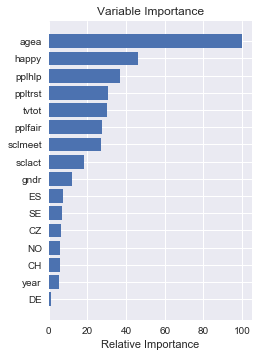

feature importance: [   5.21483674   30.18111766   30.48960644   27.26681399   37.07184496
   46.14436492   27.1733856    18.16662139   12.07082782  100.
    5.70543348    6.27058719    1.27725725    7.40583756    6.02240587
    6.58247325]
sorted_idx: [12  0 10 14 11 15 13  8  7  6  3  1  2  4  5  9]
pos: [  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5  14.5  15.5]


In [6]:
feature_importance = clf.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

print(f'feature importance: {feature_importance}')
print(f'sorted_idx: {sorted_idx}')
pos = np.arange(sorted_idx.shape[0]) + .5
print(f'pos: {pos}')

"It appears that age and self-described happiness are the most important features in predicting whether or not someone lives with a partner."

# Drill
Improve this gradient boost model. <br>
While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Strategies you might use include: <br>
- creating new features <br>
- applying more overfitting-prevention strategies like subsampling <br>
- more iterations <br>
- trying a different loss function <br>
- changing the structure of the weak learner, allowing more leaves in the tree, or other modifications

First, let's try subsampling and changing the max depth with a few different iterations. This will allow us to apply an overfitting-prevention strategy (subsampling) while also changing the structure of the weak learner over several iterations.

In [7]:
runs = []

def run_boosting (n, depth, losstype, s):
    
    clf = ensemble.GradientBoostingClassifier(n_estimators = n,
                                              max_depth = depth,
                                              loss = losstype,
                                              subsample = s
                                             )    
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    
    score = clf.score(X_test,y_test)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()

    print((
        'n_estimators: {}\n'
        'Max Depth: {}\n'
        'Subsample: {}\n\n'
        'Training set accuracy:\n'
        'Training false positives: {}\n'
        'Training false negatives: {}\n\n'
        'Test set accuracy:\n'
        'Testing false positives: {}\n'
        'Testing false negatives: {}\n\n'
        'Test Accuracy: {}\n'
        'Cross-Val Accuracy: {}\n'
        
    ).format(n, depth, s, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors, score, cv_score))
    
    results = {}
    results['Score'] = score
    results['Cross-Val Score'] = cv_score
    results['Estimators'] = n
    results['Max Depth'] = depth
    results['Subsample'] = s
    results['Type I Errors'] = test_tI_errors
    results['Type II Errors'] = test_tII_errors
    
    return results
    
ns = [10, 100, 500]
max_depths = [2,4,6,10]
losstypes = ['deviance']
subsamples = [0.1, 0.3, 0.5, 0.9, 1]

for n in ns:
    for max_depth in max_depths:
        for losstype in losstypes:
            for s in subsamples:
                results = run_boosting(n, max_depth, losstype, s)
                runs.append(results)
            
runs.sort(key = lambda run: run['Score'])
print(f'Best Run: {runs[-1]}')

n_estimators: 10
Max Depth: 2
Subsample: 0.1

Training set accuracy:
Training false positives: 0.02359519912711402
Training false negatives: 0.23731587561374795

Test set accuracy:
Testing false positives: 0.04294478527607362
Testing false negatives: 0.2294478527607362

Test Accuracy: 0.7276073619631902
Cross-Val Accuracy: 0.7362240760489505

n_estimators: 10
Max Depth: 2
Subsample: 0.3

Training set accuracy:
Training false positives: 0.019639934533551555
Training false negatives: 0.24468085106382978

Test set accuracy:
Testing false positives: 0.03803680981595092
Testing false negatives: 0.23190184049079754

Test Accuracy: 0.7300613496932515
Cross-Val Accuracy: 0.7349957799810803

n_estimators: 10
Max Depth: 2
Subsample: 0.5

Training set accuracy:
Training false positives: 0.019094380796508457
Training false negatives: 0.24536279323513366

Test set accuracy:
Testing false positives: 0.03803680981595092
Testing false negatives: 0.2343558282208589

Test Accuracy: 0.7276073619631902
Cr

In [8]:
runs.sort(key = lambda run: run['Score'])
print(f'Best Run: {runs[-1]}')

Best Run: {'Score': 0.754601226993865, 'Cross-Val Score': 0.67092454976506632, 'Estimators': 100, 'Max Depth': 4, 'Subsample': 1, 'Type I Errors': 0.062576687116564417, 'Type II Errors': 0.18282208588957055}


Compared to the baseline model, the best performing set of parameters creates a model with lower Type I errors and slightly higher Type II errors (though the difference is negligible). The testing accuracy is higher at **0.758** compared to 0.745 for the baseline model and the cross-val score is about the same around 0.67, which shows that the model is overfitting despite incorporating subsampling. This model has 100 estimators, Max Depth = 4, and Subsample = 0.5. The baseline model had 500 estimators, Max Depth = 2 and subsample = 1. A score of 0.758 is satisfactory, for now. <br><br>

Now let's try changing the loss function to exponential.

In [9]:
ns = [10, 100, 500]
max_depths = [2,4,6,10]
losstypes = ['exponential']
subsamples = [0.1, 0.3, 0.5, 0.9, 1]

exp_runs = []
for n in ns:
    for max_depth in max_depths:
        for losstype in losstypes:
            for s in subsamples:
                results = run_boosting(n, max_depth, losstype, s)
                exp_runs.append(results)
                
exp_runs.sort(key = lambda run: run['Score'])
print(f'Best Run: {exp_runs[-1]}')

n_estimators: 10
Max Depth: 2
Subsample: 0.1

Training set accuracy:
Training false positives: 0.024549918166939442
Training false negatives: 0.23240589198036007

Test set accuracy:
Testing false positives: 0.029447852760736196
Testing false negatives: 0.23680981595092024

Test Accuracy: 0.7337423312883435
Cross-Val Accuracy: 0.7332241063568742

n_estimators: 10
Max Depth: 2
Subsample: 0.3

Training set accuracy:
Training false positives: 0.016366612111292964
Training false negatives: 0.24768139661756683

Test set accuracy:
Testing false positives: 0.03067484662576687
Testing false negatives: 0.23803680981595093

Test Accuracy: 0.7312883435582822
Cross-Val Accuracy: 0.7257245076773933

n_estimators: 10
Max Depth: 2
Subsample: 0.5

Training set accuracy:
Training false positives: 0.02182214948172395
Training false negatives: 0.24386252045826515

Test set accuracy:
Testing false positives: 0.04539877300613497
Testing false negatives: 0.2282208588957055

Test Accuracy: 0.7263803680981595


In [10]:
exp_runs.sort(key = lambda run: run['Score'])
print(f'Best Run: {exp_runs[-1]}')

Best Run: {'Score': 0.754601226993865, 'Cross-Val Score': 0.6724261631263988, 'Estimators': 100, 'Max Depth': 4, 'Subsample': 1, 'Type I Errors': 0.061349693251533742, 'Type II Errors': 0.18404907975460122}


Changing the loss function to exponential (with the same combination of hyperparameters) decreased our testing score very slightly from 0.758 to **0.755**, which is a minor change. The cross-val score was almost exactly the same. With exponential loss, the algorithm works best with Subsample = 1 (as opposed to 0.5 for deviance loss).

Now I'd like to take a look at the distributions of each variable to get some information on what new variables I can create.

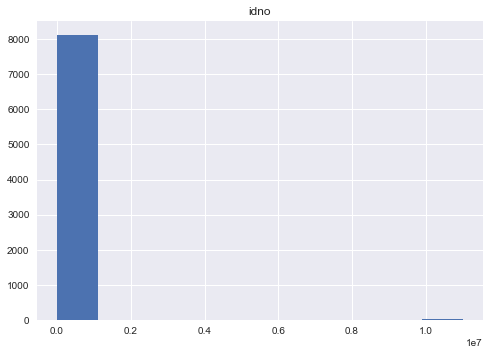

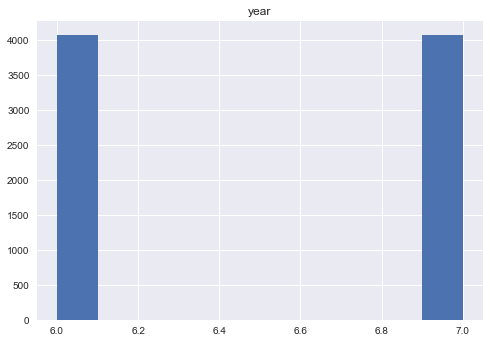

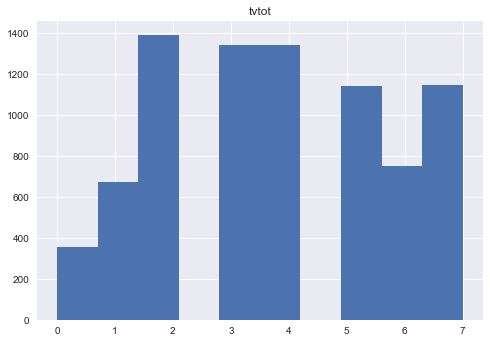

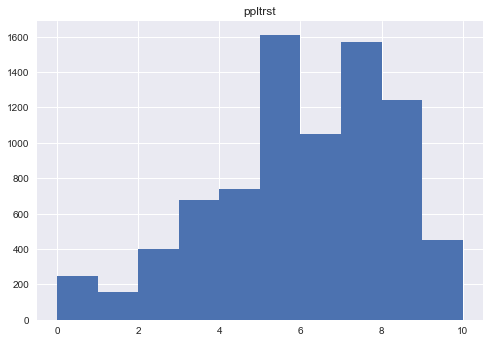

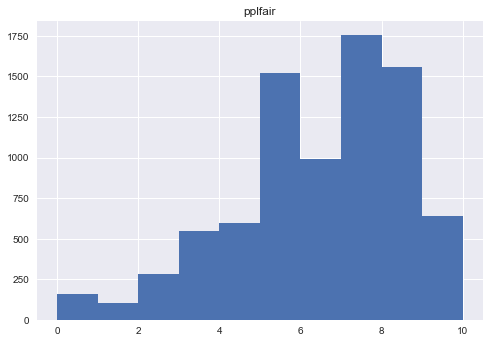

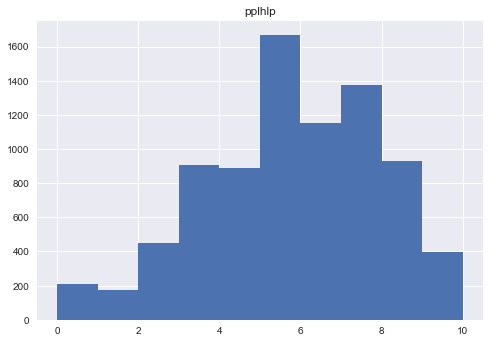

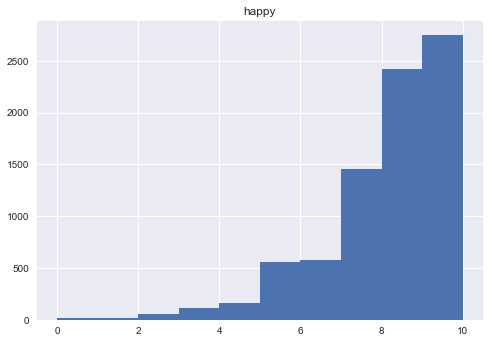

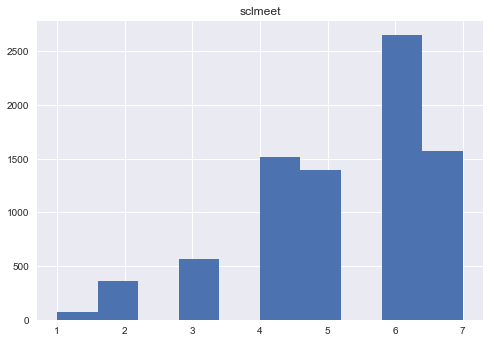

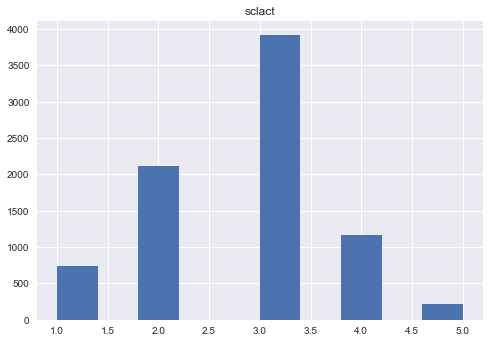

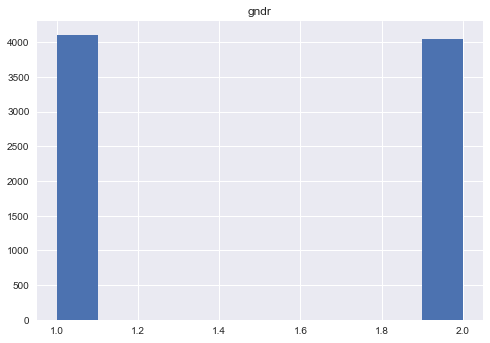

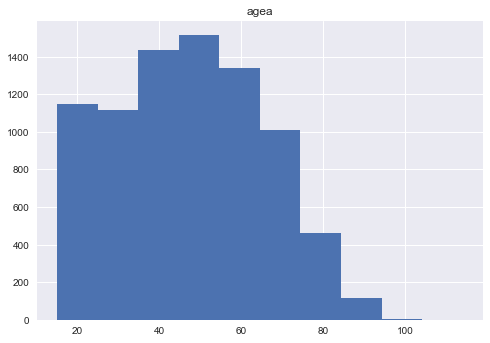

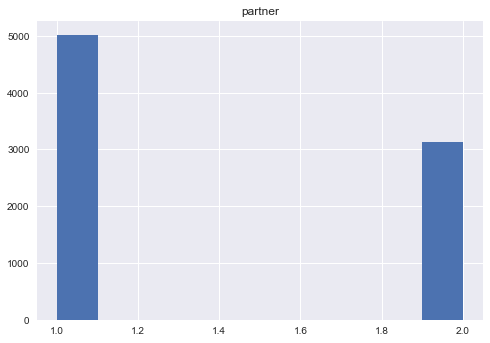

In [11]:
numerical = df.drop('cntry', axis=1)
numerical = numerical.apply(pd.to_numeric, errors='coerce')

for column in numerical:
    plt.hist(numerical[column].dropna())
    plt.title(column)
    plt.show()

IDNO has only one value, so it should be cut. Year has only 2 values and intuitively it doesn't seem like it would have a large effect on the outcome, especially since the values are only 2 years apart. Tvtot looks like it might be a useful feature with good variance and distribution. Ppltrust and pplfair look relatively the same, and have somewhat normal distributions. Pplhelp is even better, and sclact has a nice normal distribution.<br>

I would also like to see how each variable relates to the outcome, but since the outcome is binary I will have to convert it to a logistic representation of probability. I will use this converted dataframe to make numerical predictions for whether someone lives with a partner, then convert these probabilities back to binary depending on their probability being over or under 0.5. This will ensure that we are still looking at a binary outcome of interest while still being informed by logistic manipulation.

In [12]:
X_ = X
X_['intercept'] = 1 

logit = sm.Logit(y, X_)
result = logit.fit()
print(result.summary())

pred_ = result.predict(X_)
pred_binary = np.where(pred_ < .5, 0, 1)

table = pd.crosstab(y, pred_binary)

print('\n Accuracy by Partner Status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))

df['pred_'] = pred_

Optimization terminated successfully.
         Current function value: 0.605477
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                partner   No. Observations:                 8147
Model:                          Logit   Df Residuals:                     8131
Method:                           MLE   Df Model:                           15
Date:                Fri, 16 Feb 2018   Pseudo R-squ.:                 0.09130
Time:                        17:11:24   Log-Likelihood:                -4932.8
converged:                       True   LL-Null:                       -5428.4
                                        LLR p-value:                1.036e-201
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
year           0.1019      0.049      2.098      0.036         0.007     0.197
tvtot          0.0226      0.

After transforming our data to logistic probabilities then using them to forecast a binary output, we can see that our model casts predictions at **0.707** accuracy. This does not outperform the boosting model from earlier with a deviance loss function (0.758).

Let's plot each feature against the logistic probability prediction for the outcome feature. This will allow us to visualize which features have a discernible relationship with the outcome. 

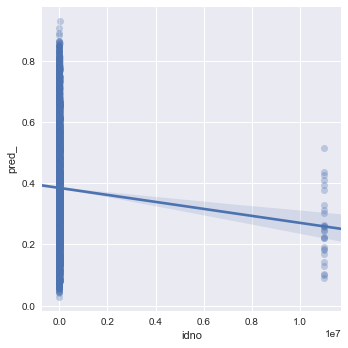

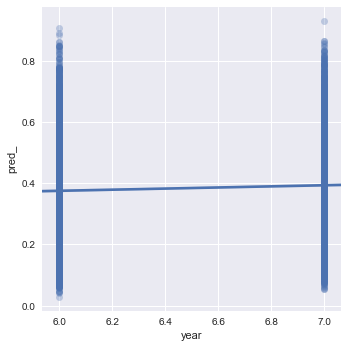

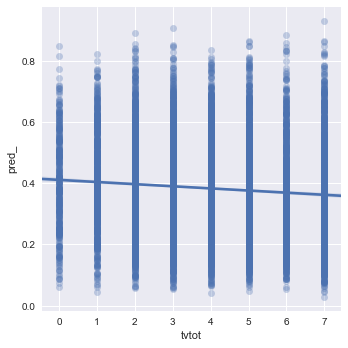

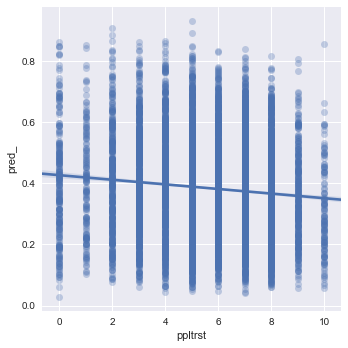

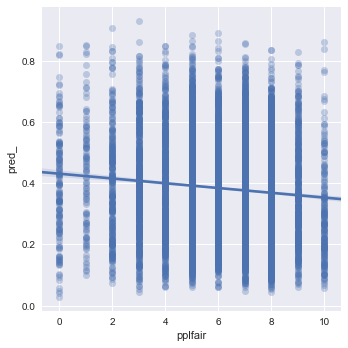

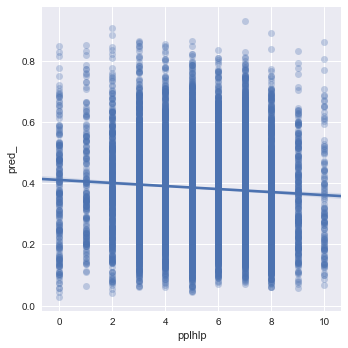

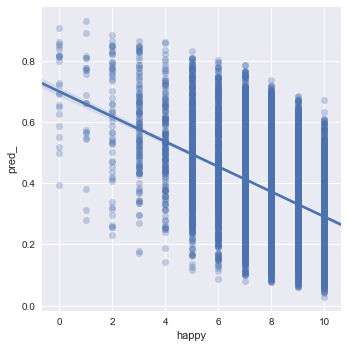

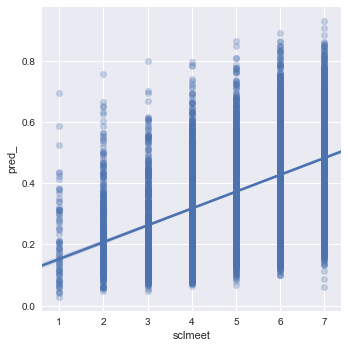

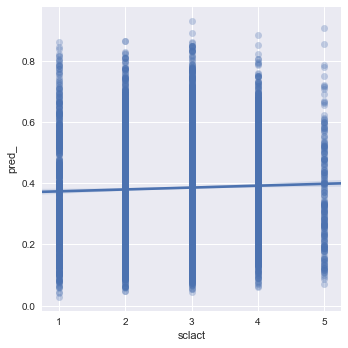

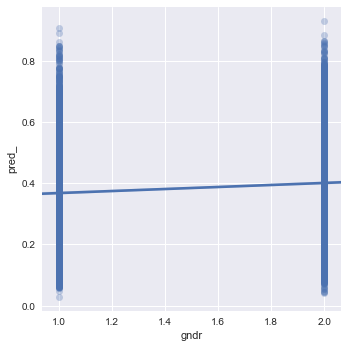

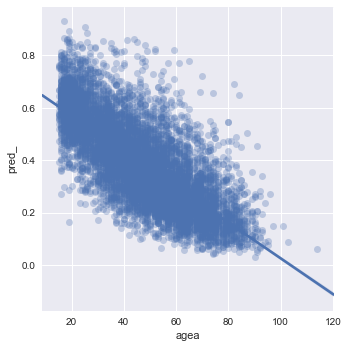

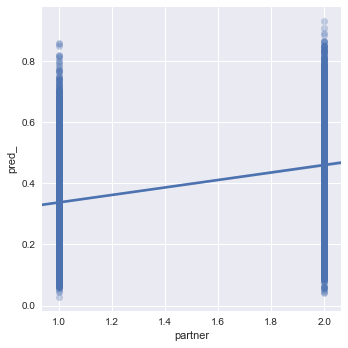

In [13]:
def plot_relationship(column):
    g = sns.lmplot (y = 'pred_',
                    x = column,
                    data = df,
                    fit_reg = True,
                    scatter_kws = {'alpha': 0.3}
                    )
    plt.show()
    
for column in numerical:
    plot_relationship(column)

ID number is irrelevant because it is arbitrarily assigned. Most of these visualizations do not benefit from converting the outcome to logistic because most features are discrete, ordinal or categorical values. Tvtot has a slightly negative correlation, as do all the categories ppltrust/pplhelp/pplfair. Happy actually has a fairly significant negative correlation, which is counterintuitive. Why is it that the happier people are less likely to live with partners? Perhaps monogamy is a sham.<br>

Now, I want to try to manipulate the "happy" feature because I know it ranks high on variable importance and because I can see that it doesn't have a normal distribution. Let's try squaring it.

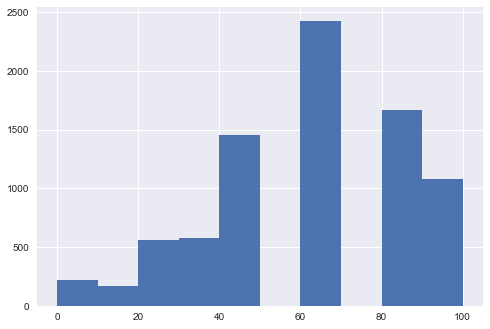

In [14]:
numerical['sqhappy'] = numerical['happy'] ** 2
plt.hist(numerical['sqhappy'])
plt.show()

This actually does make the distribution more normal! Let's try re-running the algorithm with this new variable. We will have to re-write the method a little to account for a new dataset, which will make it more robust for future use.

In [15]:
def run_boosting (X, y, n, depth, losstype, s):
    
    offset = int(X.shape[0] * 0.9)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    
    clf = ensemble.GradientBoostingClassifier(n_estimators = n,
                                              max_depth = depth,
                                              loss = losstype,
                                              subsample = s
                                             )    
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    
    score = clf.score(X_test,y_test)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()

    print((
        'n_estimators: {}\n'
        'Max Depth: {}\n'
        'Subsample: {}\n\n'
        'Training set accuracy:\n'
        'Training false positives: {}\n'
        'Training false negatives: {}\n\n'
        'Test set accuracy:\n'
        'Testing false positives: {}\n'
        'Testing false negatives: {}\n\n'
        'Test Accuracy: {}\n'
        'Cross-Val Accuracy: {}\n'
        
    ).format(n, depth, s, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors, score, cv_score))
    
    results = {}
    results['Score'] = score
    results['Cross-Val Score'] = cv_score
    results['Estimators'] = n
    results['Max Depth'] = depth
    results['Subsample'] = s
    results['Type I Errors'] = test_tI_errors
    results['Type II Errors'] = test_tII_errors
    
    return results

losstypes = ['deviance']
runs = []
X_happysq = X.copy()
X_happysq = X_happysq.drop('happy', axis = 1)
X_happysq['happysq'] = numerical['sqhappy']

for n in ns:
    for max_depth in max_depths:
        for losstype in losstypes:
            for s in subsamples:
                results = run_boosting(X_happysq, y, n, max_depth, losstype, s)
                runs.append(results)
                
runs.sort(key = lambda run: run['Score'])
print(f'Best Run: {runs[-1]}')

n_estimators: 10
Max Depth: 2
Subsample: 0.1

Training set accuracy:
Training false positives: 0.022640480087288598
Training false negatives: 0.24045280960174578

Test set accuracy:
Testing false positives: 0.04539877300613497
Testing false negatives: 0.2282208588957055

Test Accuracy: 0.7263803680981595
Cross-Val Accuracy: 0.7349957796002079

n_estimators: 10
Max Depth: 2
Subsample: 0.3

Training set accuracy:
Training false positives: 0.024413529732678668
Training false negatives: 0.23690671031096563

Test set accuracy:
Testing false positives: 0.04539877300613497
Testing false negatives: 0.2282208588957055

Test Accuracy: 0.7263803680981595
Cross-Val Accuracy: 0.7355420405512783

n_estimators: 10
Max Depth: 2
Subsample: 0.5

Training set accuracy:
Training false positives: 0.022776868521549372
Training false negatives: 0.240316421167485

Test set accuracy:
Testing false positives: 0.04539877300613497
Testing false negatives: 0.2282208588957055

Test Accuracy: 0.7263803680981595
Cros

Using a deviance loss function and changing the "happy" variable to happy squared, the score went from 0.758 to **0.755**. This is not a worthwhile change to make.<br>

Let's try normalizing our data and performing PCA to create new features.

Percentage of total variance in dataset explained by each component:
 [  1.70139538e-01   9.25375665e-02   8.25538893e-02   7.95874504e-02
   7.84020355e-02   6.52750639e-02   6.32747839e-02   6.31728753e-02
   6.15776836e-02   5.50855982e-02   4.75420920e-02   4.66442601e-02
   3.51831630e-02   3.42870435e-02   2.47369572e-02   5.92711801e-32
   0.00000000e+00]
Covariance Matrix:
 [[ 1.00012276 -0.03159981 -0.00159985  0.00428352 -0.03290507 -0.01337955
  -0.02850586  0.01215135  0.00135484 -0.00352085  0.00321829  0.00147181
   0.00210057 -0.00693634  0.00101236  0.00208514  0.        ]
 [-0.03159981  1.00012276 -0.14243921 -0.1192919  -0.06908859 -0.11861266
  -0.07887335 -0.09238642  0.01792396  0.25770606 -0.17384673  0.21863283
   0.00414498  0.03598915 -0.01762101 -0.05008121  0.        ]
 [-0.00159985 -0.14243921  1.00012276  0.59757931  0.45930654  0.23156166
   0.12257028  0.13750835 -0.02992478 -0.0294161   0.03193968 -0.22504908
  -0.00918091 -0.15251872  0.2175567   0.1326

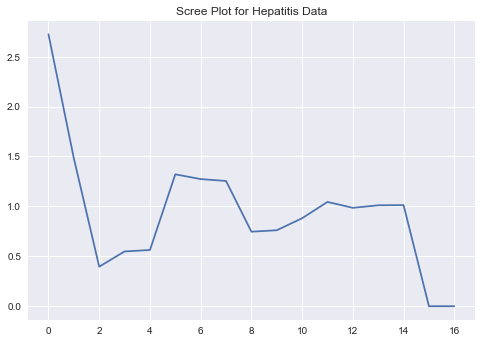

In [16]:
X_scaled = StandardScaler().fit_transform(X)
sklearn_pca = PCA()
sklearn_pca.fit(X_scaled)

print(
    'Percentage of total variance in dataset explained by each component:\n',
    sklearn_pca.explained_variance_ratio_
)

Xt = X_scaled.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.title("Scree Plot for Hepatitis Data")
plt.show()

If we are to follow the rule of keeping only the components with a covariance over 1, we wouldn't keep any of these components. Let's try a different method of component visualization and plot the cumulative explained variance.

[  17.01   26.26   34.52   42.48   50.32   56.85   63.18   69.5    75.66
   81.17   85.92   90.58   94.1    97.53  100.    100.    100.  ]


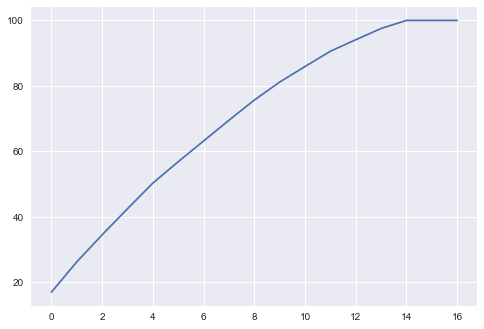

In [19]:
var1=np.cumsum(np.round(sklearn_pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

It is standard to include only enough components to comprise 85% of the variance. In this case, that would be 11 components. So, we will conduct PCA again with 11 componenets, then feed the transformed dataset into a boosting model.

In [20]:
sklearn_pca = PCA(n_components = 11)
sklearn_pca.fit(X_scaled)
X_pca = sklearn_pca.transform(X_scaled)
X_pca_df = pd.DataFrame(data=X_pca)

for n in ns:
    for max_depth in max_depths:
        for losstype in losstypes:
            for s in subsamples:
                results = run_boosting(X_pca_df, y, n, max_depth, losstype, s)
                runs.append(results)
                
runs.sort(key = lambda run: run['Score'])
print(f'Best Run: {runs[-1]}')

n_estimators: 10
Max Depth: 2
Subsample: 0.1

Training set accuracy:
Training false positives: 0.010911074740861976
Training false negatives: 0.34410801963993454

Test set accuracy:
Testing false positives: 0.0036809815950920245
Testing false negatives: 0.3717791411042945

Test Accuracy: 0.6245398773006134
Cross-Val Accuracy: 0.6388446023439975

n_estimators: 10
Max Depth: 2
Subsample: 0.3

Training set accuracy:
Training false positives: 0.015275504637206765
Training false negatives: 0.3241953082378614

Test set accuracy:
Testing false positives: 0.012269938650306749
Testing false negatives: 0.33865030674846625

Test Accuracy: 0.649079754601227
Cross-Val Accuracy: 0.6313448180526854

n_estimators: 10
Max Depth: 2
Subsample: 0.5

Training set accuracy:
Training false positives: 0.014457174031642117
Training false negatives: 0.33496999454446263

Test set accuracy:
Testing false positives: 0.007361963190184049
Testing false negatives: 0.3570552147239264

Test Accuracy: 0.6355828220858896

Using our PCA-reduced dataset with 11 components, we get a maximum testing accuracy of **0.755**, which does not surpass our earlier score of 0.758. <br>

Now, we have tried creating new features via PCA. We have applied subsampling as an overfitting-prevention strategy. We have tried 2 different loss functions, as well as modifying the structure of the weak learner over several iterations.<br>

The best performing model was a boosting model with subsampling applied at 0.5, with 100 estimators at max depth of 4. This gave us a testing accuracy score of **0.758**, which narrowly beat other models by margins less than 0.01. Through this drill, I have gained a deeper understanding of the way that gradient boosting models can be tuned, and what kind of information they can provide. Specifically, the feature importances provide lots of information as they count how many times a feature is used over the course of many decision trees. The ability to extract information from many weak learners to gain valuable insight into the dataset is a benefit of ensemble models.